# Imports

In [1]:
import torch
import sklearn
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Computer vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
#from torchvision import transforms as T


from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

# Directory libraries
import pathlib
import os
import shutil

# Extras
import random
from collections import defaultdict
from PIL import Image

# Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

# Download data

In [3]:
data_path = r'data_path/'

In [4]:
# Get training data
train_data = datasets.Food101(root=data_path,
                              split="train",                              
                              transform=v2.ToImage(),
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_path,
                             split="test",                             
                             transform=v2.ToImage(),
                             download=True)

In [5]:
type(train_data), len(train_data), len(test_data)

(torchvision.datasets.food101.Food101, 75750, 25250)

In [6]:
class_names = train_data.classes
len(class_names)

101

In [7]:
# Assuming your list is named 'my_list'
#my_list = [str(i) for i in range(101)]  # Convert elements to strings

# Number of rows and columns in the grid
num_rows = 21
num_cols = 5

# Iterate through the list and print in a grid format
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < len(class_names):
            element = class_names[index]            
            print(f'| {index} {element:<25} ', end='')  # Adjust the formatting as needed
    print("\n\n") # Move to the next line after printing each row

| 0 apple_pie                 | 1 baby_back_ribs            | 2 baklava                   | 3 beef_carpaccio            | 4 beef_tartare              


| 5 beet_salad                | 6 beignets                  | 7 bibimbap                  | 8 bread_pudding             | 9 breakfast_burrito         


| 10 bruschetta                | 11 caesar_salad              | 12 cannoli                   | 13 caprese_salad             | 14 carrot_cake               


| 15 ceviche                   | 16 cheese_plate              | 17 cheesecake                | 18 chicken_curry             | 19 chicken_quesadilla        


| 20 chicken_wings             | 21 chocolate_cake            | 22 chocolate_mousse          | 23 churros                   | 24 clam_chowder              


| 25 club_sandwich             | 26 crab_cakes                | 27 creme_brulee              | 28 croque_madame             | 29 cup_cakes                 


| 30 deviled_eggs              | 31 donuts                    

In [8]:
img, label = next(iter(train_data))

torch.Size([3, 512, 512])


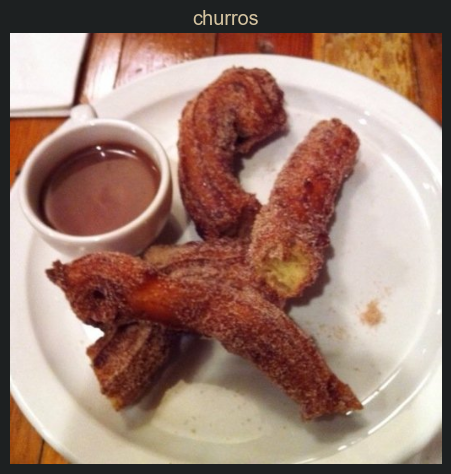

In [9]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(img.shape)

# Subset

In [10]:
# Create function to separate a random amount of data
def get_subset(data_dir=data_path,               
               data_splits=["train", "test"], 
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1):
    '''
    Function to separate a random amount of data. 
    Train - Each class contains 750 images, there are 101 different classes (750*101 = 75, 750) 
    Test - Each class contains 250 images, there are 101 different classes (250*101 = 25, 250) 
    So, the amount of data is calculated by each class pass throught `target_classes`.
    The amount is calculated for each class and then each value is added, this results in the total 
    number of examples.
    
    Example:
    If the amount is 0.1 (10%) and 5 classes are passed.
    10% is calculated for each class.
    Training data: 10% of 750 = 75, this is repeated 5 times (one time for each class)
    Total number of examples for training data: (75+75+75+75+75) = 375
    
    Testing data: 10% of 250 = 25, this is repeated 5 times (one time for each class)
    Total number of examples for testing data: (25+25+25+25+25) = 125
    
    For example, for each class it can return something like this, where each item represents the amount
    of elements for each class.
    [76, 79, 92, 53, 75] = 375
    
    Finally:
    Total number of examples are selected within the data that belong to the target classes. Hence
    the total elements for each class may vary, one class can have more elements than another and 
    vice versa.
    
    Returns: 
    This return a dictionary where the key indicates if it's training or testing data. For each
    data (training, testing) a list is returned with the image path for each image.
    '''
    
    label_splits = {}
    image_path = f'{data_dir}/food-101'
    
    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        #label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        
        # Open the txt file that contains the name of each image        
        label_path = f'{image_path}/meta/{data_split}.txt'
        with open(label_path, "r") as f:
            # Select the names that coincide with the target classes (list)
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # Total of elements to select
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        # Get random subset of target classes image ID's (list with length equal to `number_to_sample`)
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # Apply full paths
        # Create the path for each image        
        image_paths = [f'{image_path}/images/{sample_image}.jpg' for sample_image in sampled_images]
        
        # Create a dictionary with the train and test data
        label_splits[data_split] = image_paths
    return label_splits

In [11]:
def print_classes_amount(dictionary_classes, data_split):
    print(f'***** {data_split} data *****')
    total_elements = 0
    for item_class in dictionary_classes:        
        len_dict = len(dictionary_classes[item_class])
        print(f'{item_class}: {len_dict}')
        total_elements += len_dict    
    print(f'Total elements: {total_elements}' + '\n')

In [12]:
def get_amount_per_class(dict_data):
    '''
    Args:
    dict_data (dict): Dictionary where the key indicates if it's training or testing data. For each
    data (training, testing) a list is returned with the image path for each image.
    
    Return a dictionary where keys are training and testing data, each key contain another dictionary, this
    dictionary contains all item separated by class.
    For example:
    dict_split.keys() ---> ['train', 'test']
    dict_split['train'].keys() ---> ['pizza', 'tacos', 'donuts']
    dict_split['train']['pizza'] ---> ['./food_path/pizza/12345.jpg', './food_path/pizza/12346.jpg', ...]
    dict_split['train']['tacos'] ---> ['./food_path/tacos/12355.jpg', './food_path/tacos/12356.jpg', ...]    
    '''
    data_splits = list(dict_data.keys())
    # Create a defaultdict to store lists for each type
    # It creates an empty list, hence we can use `append` to add each element
    lists_dict = defaultdict(list)
    
    dict_split = {}    
        
    for data_split in data_splits:        
        for item in dict_data[data_split]:
            # Select the second part of the split (e.g. 'pizza/2572488.jpg')
            _, item_type = item.split('data/food-101/images/')
            # Select the first part of the split that contains the food type (e.g. pizza/)
            image_type, _ = item_type.split('/')
            # Append the item to the corresponding list in the dictionary
            lists_dict[image_type].append(item) 
        
        # Add the dictionary to each type of data
        dict_split[data_split] = lists_dict                    
        
        # Print the amount of each class
        print_classes_amount(lists_dict, data_split)
        
        # Reset the dictionary
        lists_dict = defaultdict(list)
    return dict_split            

In [13]:
target_classes = ['tacos', 'ramen', 'pizza', 'guacamole', 'donuts']

# Amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
# Amount of data for each class
amount_to_get = 0.3

In [14]:
dict_data = get_subset(target_classes=target_classes, amount=amount_to_get)
len(dict_data['train']), len(dict_data['test'])

[INFO] Creating image split for: train...
[INFO] Getting random subset of 1125 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 375 images for test...


(1125, 375)

In [15]:
# Amount per class
dict_per_class = get_amount_per_class(dict_data)

***** train data *****
ramen: 219
donuts: 210
tacos: 231
pizza: 203
guacamole: 262
Total elements: 1125

***** test data *****
donuts: 67
ramen: 76
guacamole: 69
pizza: 74
tacos: 89
Total elements: 375



# Move training and testing images to dedicated folders

In [16]:
def copy_images_to(destiny_path, dict_data, amount_data):
    '''
    Copy the images from the source path to the target directory path. The function creates all folder
    that are necesary.
    
    Args:    
    * destiny_path: Directory path where the images are going to be copied (if it doesn't exist, it will
    be created).    
    * dict_data: Dictionary that contains the path of each image. The firsts keys must be 'train' and
    'test', then each element of 'train' or 'test' must be the class to which the image belongs and finally
    each element of that is the directory path.
    Example:
        dict_data.keys() ---> ['train', 'test']
        dict_data['train'].keys() ---> ['tacos', 'pizza', 'sushi', ...]
        dict_data['train']['tacos'] ---> ['image_path/1234.jpg', 'image_path/1235.jpg', ...]
    * amount_data: Amount of data obtained (it's just to name the destination folder).            
    
    Return:
    Return the directory path where all images were copied.
    '''    
    
    # Get class names
    class_names = sorted(dict_per_class['train'].keys())
    
    # Create the directory name
    target_dir_name = '_'.join(class_names)
    
    
    # Create target directory    
    target_dir_path = f'{destiny_path}/{target_dir_name}_{str(int(amount_data * 100))}_percent'                
    
    if os.path.exists(target_dir_path):
        print(f"Folder: {target_dir_path[52:]} exists!")
    else:
        os.makedirs(target_dir_path, exist_ok=True)
        print(f'Directory created at: {target_dir_path[52:]}')
    print()    
    
    for image_split in dict_data:
        for img_class in dict_data[image_split]:
            dest_dir = f'{target_dir_path}/{image_split}/{img_class}'            
            dest_folder_path = os.path.join(destiny_path, dest_dir)
            os.makedirs(dest_folder_path, exist_ok=True)        
            for img_path in dict_per_class[image_split][img_class]:
                shutil.copy2(img_path, dest_folder_path)            
                print(f"[INFO] Copying {img_path[52:]} to {dest_dir[52:]}...")     
    return target_dir_path

In [17]:
#current_directory = os.getcwd()
#prueba = 'data/food-101/'
#folder_path = os.path.join(current_directory, prueba)
folder_path = r'data_path/'

In [18]:
target_path = copy_images_to(folder_path, dict_per_class, amount_to_get)

Directory created at: data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent

[INFO] Copying data/food-101/images/ramen/3030439.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/216170.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/30442.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/714255.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/31538.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/1162542.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/201889.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...


[INFO] Copying data/food-101/images/ramen/88430.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/2815151.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/2071121.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/293952.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/870987.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/3701585.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/337005.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/674178.jpg to data\food-101/donuts_guac

[INFO] Copying data/food-101/images/ramen/1166500.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/1045249.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/2773486.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/3554514.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/1385131.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/606121.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/3853628.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/ramen...
[INFO] Copying data/food-101/images/ramen/2402682.jpg to data\food-101/donuts

[INFO] Copying data/food-101/images/donuts/168471.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/2016768.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/759973.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1085096.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/3042707.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1507114.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1590095.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/2024290.jpg to data\f

[INFO] Copying data/food-101/images/donuts/1274062.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1396491.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1740980.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/685545.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/2975090.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/2851795.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/91590.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/2708704.jpg to data\fo

[INFO] Copying data/food-101/images/donuts/1452592.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/donuts/1513440.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/donuts...
[INFO] Copying data/food-101/images/tacos/2687874.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1495230.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/3381771.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1474360.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/2217693.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/560529.jpg to data\food-101/do

[INFO] Copying data/food-101/images/tacos/3194546.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/2025079.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1495685.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1413480.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/394010.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/3253644.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1135700.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/448340.jpg to data\food-101/donuts_

[INFO] Copying data/food-101/images/tacos/352904.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/718434.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/3779854.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/3846373.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/2337493.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/699031.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/519704.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/tacos...
[INFO] Copying data/food-101/images/tacos/1483183.jpg to data\food-101/donuts_gu

[INFO] Copying data/food-101/images/pizza/3392671.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/2967846.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/203831.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/579691.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/2187466.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/2010437.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/1899562.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/pizza...
[INFO] Copying data/food-101/images/pizza/2769168.jpg to data\food-101/donuts_

[INFO] Copying data/food-101/images/guacamole/638251.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2176908.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2772601.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/544446.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2673508.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2495536.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/172593.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/foo

[INFO] Copying data/food-101/images/guacamole/3600148.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2969954.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/1679913.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/2176907.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/812886.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/383800.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/food-101/images/guacamole/956079.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/train/guacamole...
[INFO] Copying data/foo

[INFO] Copying data/food-101/images/ramen/3180843.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/94432.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/653775.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/204137.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/316204.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/892822.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/1976773.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/ramen...
[INFO] Copying data/food-101/images/ramen/576196.jpg to data\food-101/donuts_guacamole_pi

[INFO] Copying data/food-101/images/pizza/1503858.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/441659.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/2343304.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/2782998.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/2165223.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/2971095.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/3281205.jpg to data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent/test/pizza...
[INFO] Copying data/food-101/images/pizza/94215.jpg to data\food-101/donuts_guacamol

# Becoming one with the data (data preparation and data exploration)

In [19]:
def walk_through_dir(dir_path):
    '''
    Walks through dir_path returning it's contents.
    '''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in ./{dirpath[52:]}')

In [20]:
walk_through_dir(target_path)

There are 2 directories and 0 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent
There are 5 directories and 0 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test
There are 0 directories and 67 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test\donuts
There are 0 directories and 69 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test\guacamole
There are 0 directories and 74 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test\pizza
There are 0 directories and 76 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test\ramen
There are 0 directories and 89 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\test\tacos
There are 5 directories and 0 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\train
There are 0 directories and 210 images in ./data\food-101/donuts_guacamole_pizza_ramen_tacos_30_percent\trai

In [21]:
# Setup train and testing data
TRAIN_DIR = target_path + '/train'
TEST_DIR = target_path + '/test'

# Transforming data

Before we can use our image data with Pytorch:  
1.- Turn our target data into tensors (in our case, numerical representation of our images)  
2.- Turn it into a `torch.util.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [22]:
# Write a transform for image
data_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256, 256)),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transform for Image Augmentation
data_transform_2 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256, 256)),
    v2.RandomVerticalFlip(0.5),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomGrayscale(p=0.1),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [23]:
reverse_normalize = v2.Compose([    
    v2.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5])    
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


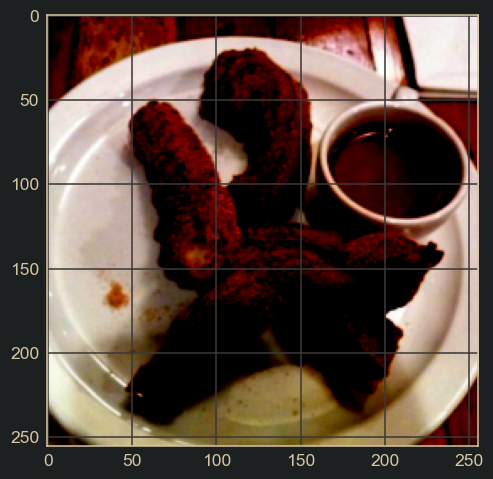

In [24]:
a = data_transform(img)  
plt.imshow(a.permute(1, 2, 0))

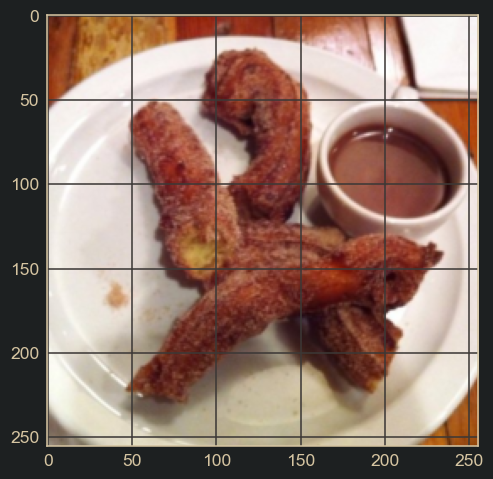

In [25]:
a_2 = reverse_normalize(a)
plt.imshow(a_2.permute(1, 2, 0))

# Dataset

In [26]:
class Food_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        #self.root_dir = root_dir
        self.images = self.get_jpg_files(root_dir)
        #self.classes = {value: idx for idx, value in enumerate(sorted(os.listdir(root_dir)))}
        self.classes = sorted(os.listdir(root_dir))
        self.dict_classes = {value: idx for idx, value in enumerate(self.classes)}
        self.transform = transform                

    def get_jpg_files(self, root_path):
        jpg_files = []        
        for root, dirs, files in os.walk(root_path):
            for idx, file in enumerate(files):                
                if file.endswith('.jpg'):
                    jpg_files.append(os.path.join(root, file))
        return jpg_files
                    
    def __len__(self):        
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        class_name = os.path.basename(os.path.dirname(image_path))
        class_idx = self.dict_classes[class_name]
        
        if self.transform:
            image = self.transform(image)
        else:
            trans = v2.ToImage()
            image = trans(image)
        #image /= 255
        
        return image, class_idx

In [27]:
train_dataset_1 = Food_Dataset(TRAIN_DIR, data_transform)
train_dataset_2 = Food_Dataset(TRAIN_DIR, data_transform_2)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
test_dataset = Food_Dataset(TEST_DIR, data_transform)
len(train_dataset), len(test_dataset)

(2250, 375)

In [28]:
dataset_classes = train_dataset_1.classes
dict_classes = train_dataset_1.dict_classes
dataset_classes, dict_classes

(['donuts', 'guacamole', 'pizza', 'ramen', 'tacos'],
 {'donuts': 0, 'guacamole': 1, 'pizza': 2, 'ramen': 3, 'tacos': 4})

# DataLoader

In [29]:
BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0
# 80% train size
TRAIN_SIZE = int(len(train_dataset) * 0.8)

# 20% val size
VAL_SIZE = len(train_dataset) - TRAIN_SIZE
TRAIN_SIZE, VAL_SIZE, NUM_WORKERS

(1800, 450, 0)

In [30]:
# Split train dataset into train and validation
train_dataset, val_dataset = random_split(train_dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_dataset), len(val_dataset)

(1800, 450)

In [31]:
# DataLoader creation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [32]:
print('Number of batches per loader')
print(f'Train loader: {len(train_loader)} | Val loader: {len(val_loader)} | Test loader: {len(test_loader)}')

Number of batches per loader
Train loader: 57 | Val loader: 15 | Test loader: 12


# Let's see the data

In [33]:
imgs, labels = next(iter(val_loader))
imgs.shape, len(labels)

(torch.Size([32, 3, 256, 256]), 32)

In [34]:
def plot_images(images_tensor, labels_tensor, class_names, is_normalized=False, preds=None):
    '''
    Plot images in batches.
    
    Args:
    images_tensor: Batch of Tensor images with shape (N, C, H, W), where:
        * `N` is a number of images in the batch.
        * `C` is the number of channels.
        * `H` and `W` refer to height and width.
    labels_tensor: Tensor with labels of each image.
    class_name: List with the name of each class.
    preds: Prediction for each image.
    '''
    batch_size = images_tensor.shape[0]
    
    columns = 4
    if batch_size == 32:
        rows = 8        
    elif batch_size == 64:
        rows = 16        
    else:
        rows = 32
    
    plt.figure(figsize=(20, 20))
    
    for image_n in range(batch_size):
        plt.subplot(rows, columns, image_n+1)
        image = images_tensor[image_n]
        if is_normalized:
            image = reverse_normalize(image)
        plt.imshow(image.permute(1, 2, 0))
        label_txt = class_names[labels_tensor[image_n]]
        if preds is not None:
            pred_txt = class_names[preds[image_n]]
            if label_txt == pred_txt:
                plt.title(f'Real: {label_txt} | Pred: {pred_txt}', c='g')
            else:
                plt.title(f'Real: {label_txt} | Pred: {pred_txt}', c='r')            
        else:
            plt.title(label_txt)
        plt.axis(False)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


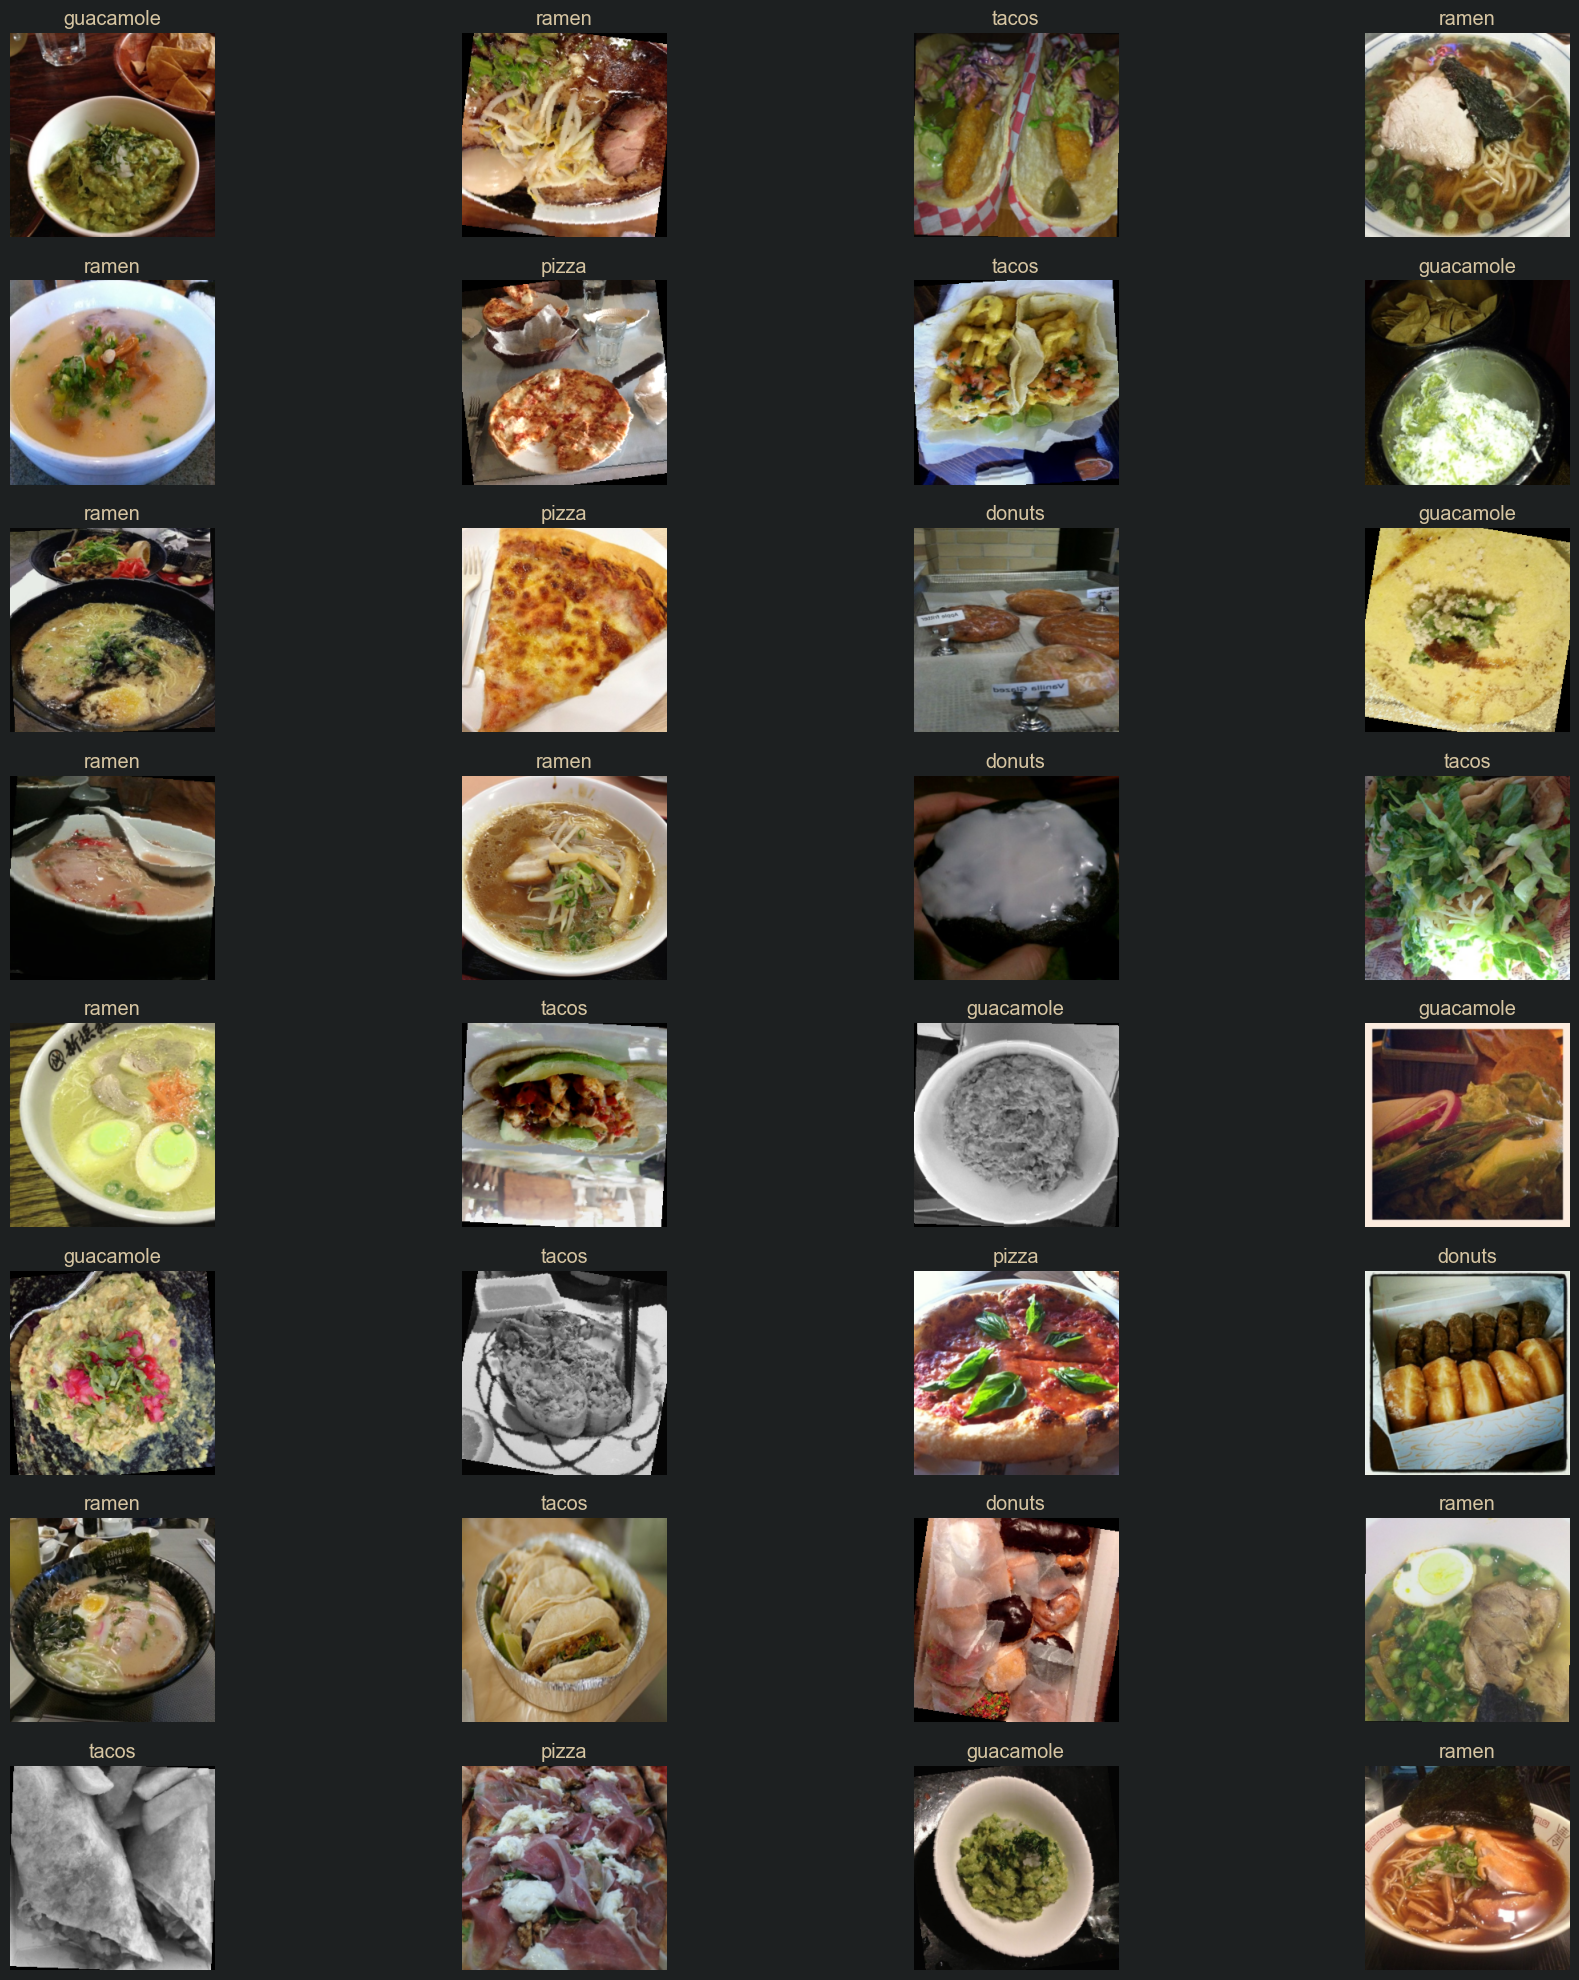

In [35]:
plot_images(imgs, labels, dataset_classes, is_normalized=True)

# Create the model

In [55]:
class Basic_Block(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.block = nn.Sequential(
                        nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1),
                        nn.BatchNorm2d(n_features),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1),
                        nn.BatchNorm2d(n_features))
        self.act_fn = nn.ReLU()
    def forward(self, x):
        res = x
        blck = self.block(x)
        add_res = blck + res
        return self.act_fn(add_res)

In [56]:
class Donwsampling_Block(nn.Module):
    def __init__(self, input_channels, n_features):
        super().__init__()
        self.block = nn.Sequential(
                        nn.Conv2d(in_channels=input_channels, out_channels=n_features, 
                                  kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(n_features),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=n_features, out_channels=n_features, 
                                  kernel_size=3, padding=1),
                        nn.BatchNorm2d(n_features))
        
        self.downsampling = nn.Conv2d(in_channels=input_channels, out_channels=n_features, 
                                      kernel_size=1, stride=2)
        
        self.act_fn = nn.ReLU()
    
    def forward(self, x):
        down_s = self.downsampling(x)
        blck = self.block(x)
        add_res = blck + down_s
        return self.act_fn(add_res)

In [58]:
class ResNet_34(nn.Module):
    def __init__(self, input_channels, output_features):
        super().__init__()
        self.conv_1 = nn.Sequential(
                        nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=7, 
                                  stride=2, padding=3),    
                        nn.BatchNorm2d(num_features=64),                        
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.layer_1 = nn.Sequential(
                        Basic_Block(n_features=64),
                        Basic_Block(n_features=64),
                        Basic_Block(n_features=64))
        self.layer_2 = nn.Sequential(
                        Donwsampling_Block(input_channels=64, n_features=128),
                        Basic_Block(n_features=128),
                        Basic_Block(n_features=128),
                        Basic_Block(n_features=128))
        self.layer_3 = nn.Sequential(
                        Donwsampling_Block(input_channels=128, n_features=256),
                        Basic_Block(n_features=256),
                        Basic_Block(n_features=256),
                        Basic_Block(n_features=256),
                        Basic_Block(n_features=256),
                        Basic_Block(n_features=256))
        self.layer_4 = nn.Sequential(
                        Donwsampling_Block(input_channels=256, n_features=512),
                        Basic_Block(n_features=512),
                        Basic_Block(n_features=512))
        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatt = nn.Flatten()
        self.fc = nn.Linear(in_features=3*3*512, out_features=output_features)
        
    def forward(self, x):
        conv1 = self.conv_1(x)        
        ly1 = self.layer_1(conv1)        
        ly2 = self.layer_2(ly1)        
        ly3 = self.layer_3(ly2)        
        ly4 = self.layer_4(ly3)        
        pool = self.avg_pool(ly4)
        print(f'avg pool: {pool.shape}')
        flatten = self.flatt(pool)
        return self.fc(flatten)

# Accuracy function

In [ ]:
def accuracy(model, val_loader, get_loss=False):
    model = model.to(device)
    model.eval()
    
    total_data = 0
    total_correct = 0
    avg_loss = 0
    
    
    with torch.inference_mode():
        for x, y in val_loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

            y_logits = model(x)
            y_preds = torch.argmax(y_logits, dim=1)
            if get_loss:
                avg_loss += F.cross_entropy(input=y_logits, target=y).item()
                                            
            total_data += len(y)
            total_correct += (y == y_preds).sum()
        avg_acc = total_correct / total_data
        #print(f'ACC | get_loss: {get_loss}')
        #print(avg_loss)
        #print(len(val_loader))
        #print()
        avg_loss /= len(val_loader)
    
    if get_loss:
        return avg_acc, avg_loss
    else:
        return avg_acc

# Train function

* `train_step()` - Takes in a model and dataloader and trains the model on the dataloader.  
* `test_step()`  - Takes in a model and dataloader and evaluates the model on the dataloader.

In [38]:
# Create the train step()
def train_step(model: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              dataloader: torch.utils.data.DataLoader,                            
              loss_fn: torch.nn.Module,
              device=device,
              scheduler: torch.optim.lr_scheduler._LRScheduler = None):
    
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader
    for x, y in dataloader:
        # Send data to the target divice
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)
        
        # 1. Forward pass
        y_logits = model(x)
        
        # Calculate accuracy metric
        y_pred = torch.argmax(y_logits, dim=1)
        train_acc += (y == y_pred).sum().item() / len(y)
        
        # 2. Calculate the loss
        loss = loss_fn(input=y_logits, target=y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Scheduler step
        if scheduler: scheduler.step()
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [39]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn = torch.nn.Module,
             device=device):
    
    # Put the model in eval mode
    model.eval()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
    
        # Loop through data loader
        for x, y in dataloader:
            # Send data to the target device
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            
            # 1. Forward pass
            y_logits = model(x)
            
            # Calculate accuracy metric
            y_preds = torch.argmax(y_logits, dim=1)
            test_acc += (y == y_preds).sum().item() / len(y)
            
            # 2. Calculate the loss
            loss = loss_fn(input=y_logits, target=y)
            test_loss += loss.item()
        
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [40]:
def train(model: torch.nn.Module,
           optimizer: torch.optim.Optimizer,            
           train_loader: torch.utils.data.DataLoader,
           val_loader: torch.utils.data.DataLoader,
           loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
           epochs: int = 50,           
           device: str = device,
           scheduler: torch.optim.lr_scheduler._LRScheduler = None):
    
    model = model.to(device)
    
    # Create empty results dictionary
    results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, optimizer, train_loader, loss_fn)
        
        test_loss, test_acc = test_step(model, val_loader, loss_fn)
        
        # Print out what's happening
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} |', end =' ')
        print(f'Train acc: {train_acc:.5f} | Test acc: {test_acc:.5f}')
        
        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    return results

# Make predictions function

In [48]:
def make_predictions(model, data_loader):
    '''
    Meke predictions from a data loader.
    
    Args:
    model: Model to make predictions
    data_loader: DataLoader that contains a number of batches, each batch contains a number of images
    with their labels.
    
    Return:
    Return a dictionary with all images, labels and predictions per batch.
    '''
    model = model.to(device)
    preds_list = []
    X_data = []
    y_label = []
    for x, y in data_loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        
        y_logits = model(x)
        y_preds = torch.argmax(y_logits, dim=1)
        
        preds_list.append(y_preds.cpu())
        X_data.append(x.cpu())
        y_label.append(y.cpu())
    
    return {'Images': X_data, 'Label': y_label, 'Preds': preds_list}        

# Plot curves

In [49]:
def plot_loss_acc_curves(results: dict[str, list[float]]):    
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize=(12, 6))
    #plt.figure(figsize=(15, 7))      
    
    #a = [i.cpu() for i in results_5['train_acc']]
    #b = [i.cpu() for i in results_5['test_acc']]
    
    plt.subplot(1, 2, 1)
    plt.title('Losses curves')
    plt.plot(epochs, results['train_loss'], label='Train')
    plt.plot(epochs, results['test_loss'], label='Test')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Accuracies curves')
    #plt.plot(epochs, a, label='Train')
    #plt.plot(epochs, b, label='Test')
    plt.plot(epochs, results['train_acc'], label='Train')
    plt.plot(epochs, results['test_acc'], label='Test')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Use torchinfo to get an idea of the shapes going through our model

In [50]:
# Install torchinfo, import if it's available 
try:
    import torchinfo
except: 
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

In [59]:
model_info = ResNet_34(input_channels=3, output_features=len(dataset_classes))
summary(model_info, input_size=[32, 3, 256, 256])

avg pool: torch.Size([32, 512, 3, 3])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet_34                                [32, 5]                   --
├─Sequential: 1-1                        [32, 64, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        9,472
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        128
│    └─MaxPool2d: 2-3                    [32, 64, 64, 64]          --
├─Sequential: 1-2                        [32, 64, 64, 64]          --
│    └─Basic_Block: 2-4                  [32, 64, 64, 64]          --
│    │    └─Sequential: 3-1              [32, 64, 64, 64]          74,112
│    │    └─ReLU: 3-2                    [32, 64, 64, 64]          --
│    └─Basic_Block: 2-5                  [32, 64, 64, 64]          --
│    │    └─Sequential: 3-3              [32, 64, 64, 64]          74,112
│    │    └─ReLU: 3-4                    [32, 64, 64, 64]          --
│    └─Basic_Block: 2-6                  [32, 64, 64, 64]          --
│  